In [17]:
%matplotlib inline

In [18]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [24]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
#PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release_20150715/bin'
PROGRAM_PATHS = '/scratch/BS/release-20160211/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from nipype.interfaces.ants import DenoiseImage
from SEMTools import *

In [37]:
import nibabel as nib
from dipy.io import read_bvals_bvecs
import dipy.reconst.dti as dti
import subprocess
import numpy as np
#import pandas as pd
#from ggplot import *

In [29]:
DWISCAN='/Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_175/0868/24132/Outputs/CorrectedDWI_in_T2Space.nrrd'
OUTPUTDIR='/scratch/dipy/tests/1_apr16/output'

In [28]:
#run DWIConvert to convert nrrd to nifti
dwiConvert = DWIConvert()
dwiConvert.inputs.inputVolume = DWISCAN
dwiConvert.inputs.conversionMode = 'NrrdToFSL'
dwiConvert.inputs.outputVolume = os.path.join(OUTPUTDIR,'testFSL.nii.gz')
print(dwiConvert.cmdline)
dwiConvert.run()

INFO:interface:stderr 2016-04-26T12:40:03.513991:Missing argument B Values
INFO:interface:stderr 2016-04-26T12:40:03.513991:Missing argument B Vectors


 DWIConvert  --conversionMode NrrdToFSL --inputVolume /Shared/johnsonhj/HDNI/20150319_DWIProcessing/Results/PHD_175/0868/24132/Outputs/CorrectedDWI_in_T2Space.nrrd --outputVolume /scratch/dipy/tests/1_apr16/output/testFSL.nii.gz


In [32]:
# another way to run DWIConvert
'''
PROGRAM_PATH='/scratch/BS/release-20160211/bin'

print("Making some nifti formatted data")
arg1='--inputVolume'+' '+str(DWISCAN)
arg2='--conversionMode NrrdToFSL'
arg3='--outputVolume'+' '+os.path.join(OUTPUTDIR,'testFSL.nii.gz')
subprocess.call([os.path.join(PROGRAM_PATH,'DWIConvert'), arg1, arg2, arg3])
'''

'\nPROGRAM_PATH=\'/scratch/BS/release-20160211/bin\'\n\nprint("Making some nifti formatted data")\narg1=\'--inputVolume\'+\' \'+str(DWISCAN)\narg2=\'--conversionMode NrrdToFSL\'\narg3=\'--outputVolume\'+\' \'+os.path.join(OUTPUTDIR,\'testFSL.nii.gz\')\nsubprocess.call([os.path.join(PROGRAM_PATH,\'DWIConvert\'), arg1, arg2, arg3])\n'

In [57]:
# use nibabel to read nifti formatted DWI data
nifti_file=os.path.join(OUTPUTDIR,'testFSL.nii.gz')
fbvec=os.path.join(OUTPUTDIR,'testFSL.bvec')
fbval=os.path.join(OUTPUTDIR,'testFSL.bval')

img = nib.load(nifti_file)
data = img.get_data()

In [58]:
print(data.shape)
print(img.get_header().get_zooms()[:3])

(128, 128, 70, 31)
(2.0, 2.0000024, 2.4999955)


In [59]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

In [60]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [61]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data)

In [62]:
print('Computing tensor ellipsoids in a part of the splenium of the CC')

from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

from dipy.viz import fvtk
ren = fvtk.ren()

evals = tenfit.evals[13:43, 44:74, 28:29]
evecs = tenfit.evecs[13:43, 44:74, 28:29]

Computing tensor ellipsoids in a part of the splenium of the CC


In [63]:
tensor_odfs = tenmodel.fit(data[20:50, 55:85, 38:39]).odf(sphere)

fvtk.add(ren, fvtk.sphere_funcs(tensor_odfs, sphere, colormap=None))
#fvtk.show(r)
print('Saving illustration as tensor_odfs.png')
fvtk.record(ren, n_frames=1, out_path='tensor_odfs.png', size=(600, 600))

Saving illustration as tensor_odfs.png


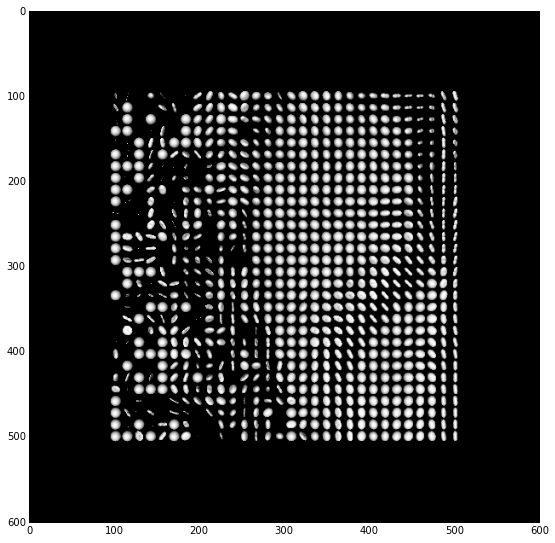

In [64]:
tensor_odfs = sitk.ReadImage('tensor_odfs.png')
myshow(tensor_odfs)

In [48]:
print('Computing anisotropy measures (FA, MD, RGB)')
from dipy.reconst.dti import fractional_anisotropy, color_fa, lower_triangular

FA = fractional_anisotropy(tenfit.evals)

Computing anisotropy measures (FA, MD, RGB)


In [49]:
FA[np.isnan(FA)] = 0

In [50]:
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)

In [51]:
cfa = RGB[13:43, 44:74, 28:29]
cfa /= cfa.max()

fvtk.add(ren, fvtk.tensor(evals, evecs, cfa, sphere))

print('Saving illustration as tensor_ellipsoids.png')
fvtk.record(ren, n_frames=1, out_path='tensor_ellipsoids.png', size=(600, 600))

Saving illustration as tensor_ellipsoids.png


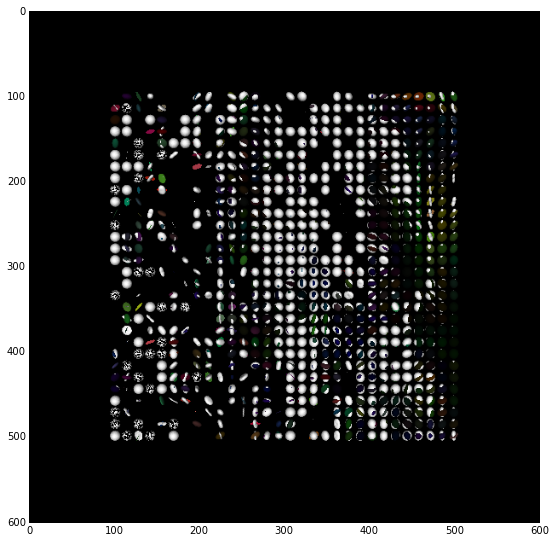

In [52]:
tensor_ellipsoids = sitk.ReadImage('tensor_ellipsoids.png')
myshow(tensor_ellipsoids)